In [212]:
import pandas as pd
import numpy as np
import csv
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import xgboost as xgb
import scipy
from geopy import distance
import geopy
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn import preprocessing
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
sns.set()


#### Read Data

In [133]:
PATH_TRAIN_DATASET = './data/train.csv'
PATH_TEST_DATASET = './data/test.csv'
PATH_SAMPLE_SUMBISSION = './data/sample_submission.csv'

In [134]:
df_test = pd.read_csv(PATH_TEST_DATASET, infer_datetime_format=True, parse_dates=['pickup_datetime'],  index_col='id')
df_train = pd.read_csv(PATH_TRAIN_DATASET, infer_datetime_format=True,parse_dates=['pickup_datetime'], index_col='id')
df_sample_submission = pd.read_csv(PATH_SAMPLE_SUMBISSION)
df_original_train = df_train.copy()
df_original_test = df_test.copy()

#### A brief description of the data

As mentioned in the challenge's page, the provided training dataset contains the following fields, as can be verified bellow:

- `id` - a unique identifier for each trip
- `vendor_id` - a code indicating the provider associated with the trip record
- `pickup_datetime` - date and time when the meter was engaged
- `dropoff_datetime` - date and time when the meter was disengaged
- `passenger_count` - the number of passengers in the vehicle (driver entered value)
- `pickup_longitude` - the longitude where the meter was engaged
- `pickup_latitude` - the latitude where the meter was engaged
- `dropoff_longitude` - the longitude where the meter was disengaged
- `dropoff_latitude` - the latitude where the meter was disengaged
- `store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server -`Y`=store and forward; `N`=not a store and forward trip
- `trip_duration` - duration of the trip in seconds

In [135]:
df_train.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

In [136]:
df_train.head(5)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


#### No Null Columns

It's important to notice that the provided database has been already preprocessed and cleaned, so no null values can be found in the base.

In [137]:
df_train.isnull().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

## Analyzing the whole Dataset

#### Prepare the data for analysis

Before the analysis, a few steps must be done to prepare the data. Also, the dropoff_datetime column will be dropped because it's redundant since we have the trip_duration.

In [138]:
df_train['pickup_datetime'] = df_train['pickup_datetime'].dt.to_pydatetime()
df_test['pickup_datetime'] = df_test['pickup_datetime'].dt.to_pydatetime()
df_train.drop('dropoff_datetime', axis=1, inplace=True)

#### Trip Duration

Since trip duration is the target variable, it will be the first to be checked. After aplying the describe function, a few strange values appear, like the min and max values, 1s and 3526282s (almost 980h) respectively. Trips with a such a low or high values for duration can decrease the accuracy of our model.

In [139]:
df_train['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

To get rid of the outliers, lets apply the the [Interquartile Range](https://en.wikipedia.org/wiki/Interquartile_range) technique

In [148]:
Q1 = df_train['trip_duration'].quantile(0.25)
Q3 = df_train['trip_duration'].quantile(0.75)
IQR = Q3 - Q1
df_train = df_train[~((df_train['trip_duration'] < (Q1 - 1.5 * IQR)) |(df_train['trip_duration'] > (Q3 + 1.5 * IQR)))]
df_train['trip_duration'].describe()

count    1.384424e+06
mean     7.317026e+02
std      4.481081e+02
min      1.000000e+00
25%      3.840000e+02
50%      6.320000e+02
75%      9.910000e+02
max      2.092000e+03
Name: trip_duration, dtype: float64

Even applying the IQR technique, the minimum value for a trip duration keeps very low, so values bellow 90 seconds will also be disconsidered.

In [161]:
df_train = df_train[df_train['trip_duration'] > 90]

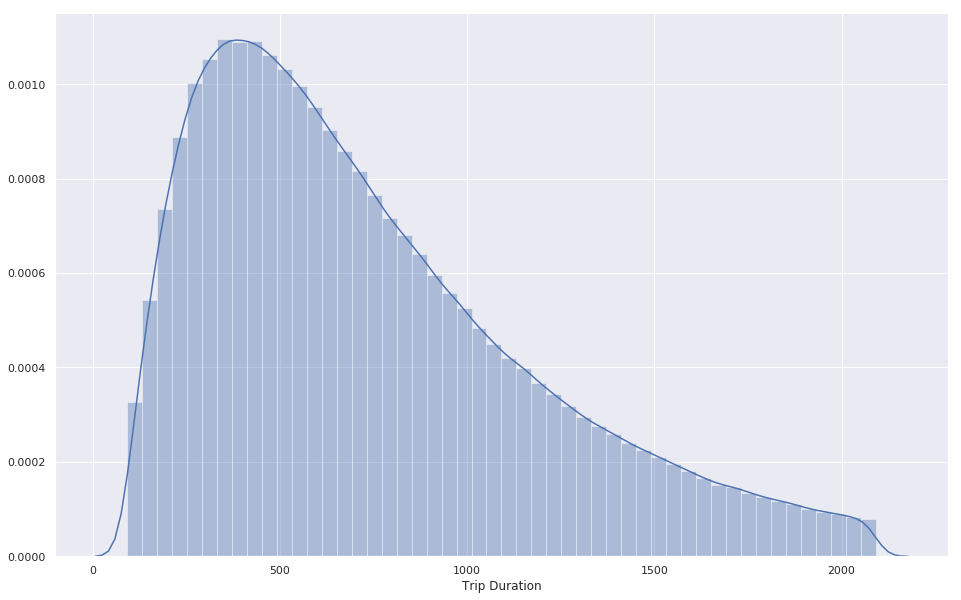

In [213]:
sns.distplot(df_train['trip_duration'], axlabel='Trip Duration')

#### Analyzing the Lat-Long Columns

To understand the distribution we must plot the values for each of the Latitude and Longitude provided. From the graph is possible to see that there are some datapoints from trips starting and finishing outside NYC.

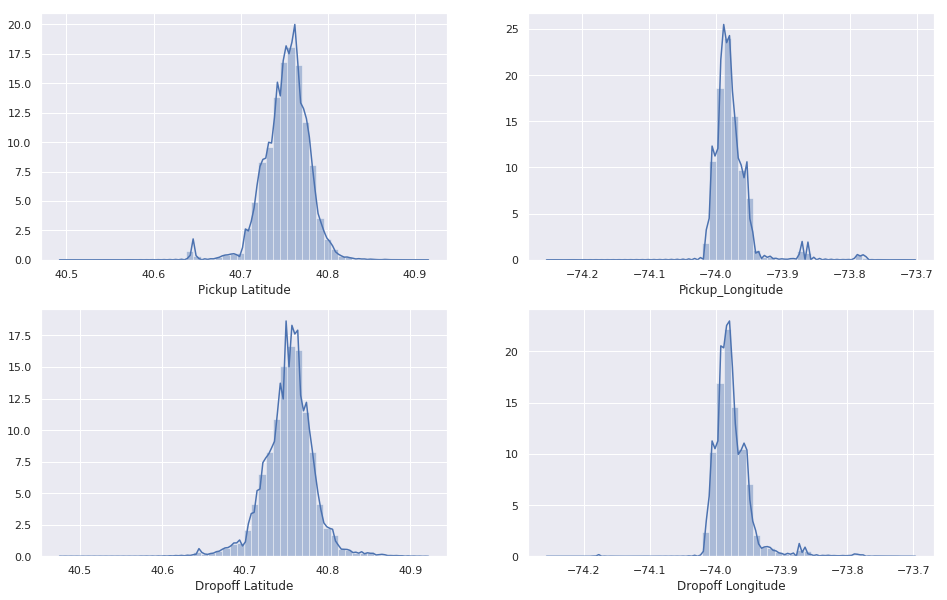

In [164]:
def plot_lat_long(df_data):
    fig, ax = plt.subplots(2,2,figsize=(16, 10), sharex=False, sharey = False)
    sns.distplot(df_data['pickup_latitude'], axlabel = 'Pickup Latitude',ax=ax[0,0])
    sns.distplot(df_data['pickup_longitude'], axlabel = 'Pickup_Longitude', ax=ax[0,1])
    sns.distplot(df_data['dropoff_latitude'], axlabel = 'Dropoff Latitude', ax=ax[1, 0])
    sns.distplot(df_data['dropoff_longitude'], axlabel = 'Dropoff Longitude', ax=ax[1, 1])
    plt.show()
plot_lat_long(df_train)

#### Drop Values Starting or Finishing out of New York City

Select values only within the NYC bounding Box

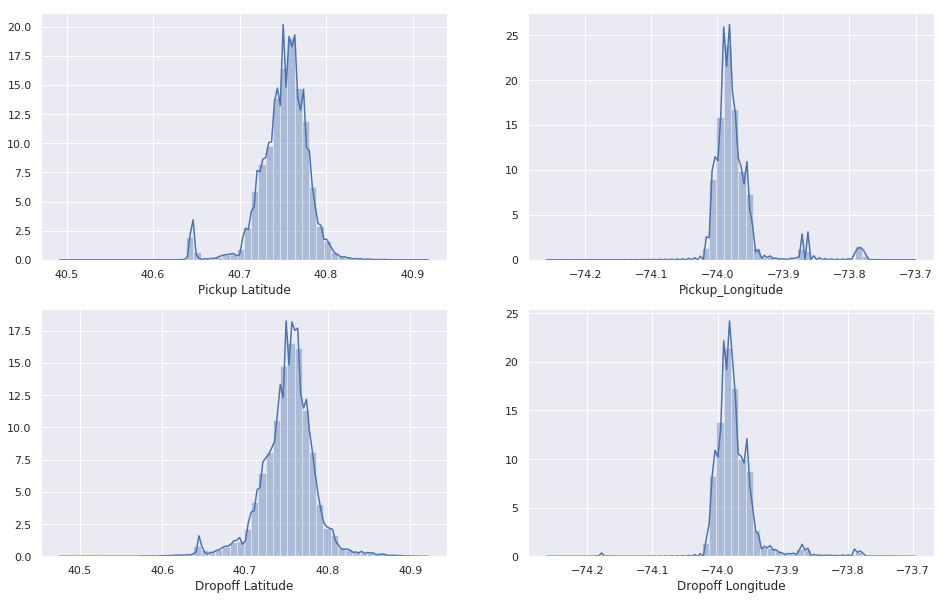

In [165]:
NYC_BOUNDING_BOX = [(40.4774,-74.2589), ( 40.9176, -73.7004)]

filter_lat_long = df_train['pickup_latitude'] < NYC_BOUNDING_BOX[1][0]
filter_lat_long &= df_train['pickup_latitude'] > NYC_BOUNDING_BOX[0][0]
filter_lat_long &= df_train['pickup_longitude'] < NYC_BOUNDING_BOX[1][1]
filter_lat_long &= df_train['pickup_longitude'] > NYC_BOUNDING_BOX[0][1]

filter_lat_long &= df_train['dropoff_latitude'] < NYC_BOUNDING_BOX[1][0]
filter_lat_long &= df_train['dropoff_latitude'] > NYC_BOUNDING_BOX[0][0]
filter_lat_long &= df_train['dropoff_longitude'] < NYC_BOUNDING_BOX[1][1]
filter_lat_long &= df_train['dropoff_longitude'] > NYC_BOUNDING_BOX[0][1]

df_train = df_train[filter_lat_long]

plot_lat_long(df_train_processed)

#### Extracting New Features: DIstance and Average Speed

Two more features will be added using the fields provided. Since we have the coorinates from the pickup and dropoff points, we can calculate the distance between points. The distance function chosen for that is the Manhattan Distance, City Block distance or [Taxicab geometry](https://en.wikipedia.org/wiki/Taxicab_geometry). The final distance is given in Kilometers

The other feature is the average speed for the whole route, for that we will use the distance obtained in the previous step and the trip duration. The average speed will be in Kilometer per hour


In [166]:
NYC_LAT_KILOMETER_PER_DEGREE = geopy.distance.distance((40.7831, -73.9712),(41.7831, -73.9712)).kilometers
NYC_LON_KILOMETER_PER_DEGREE = geopy.distance.distance((40.7831, -73.9712),(40.7831, -72.9712)).kilometers

def calculate_city_block_distance(df_data):
    delta_lat = np.abs(df_data.pickup_latitude - df_data.dropoff_latitude) * NYC_LAT_KILOMETER_PER_DEGREE    
    delta_lon = np.abs(df_data.pickup_longitude - df_data.dropoff_longitude) * NYC_LON_KILOMETER_PER_DEGREE    
    return delta_lat + delta_lon


df_train['distance'] = calculate_city_block_distance(df_train)
df_train['avg_speed'] = df_train['distance']/(df_train['trip_duration']/3600)

### Analyzing Distance and Average Speed


/home/luciano/Install/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


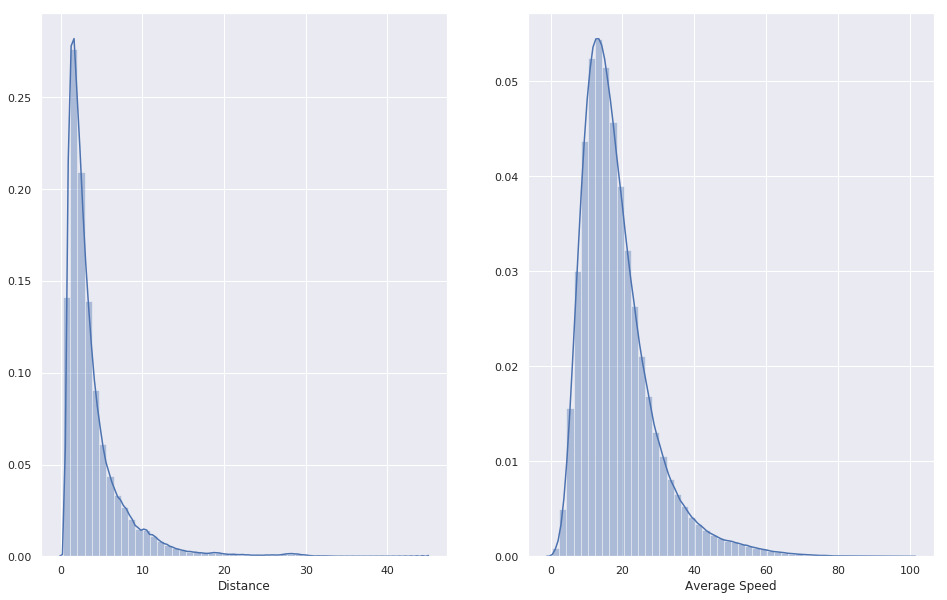

In [180]:
fig, ax = plt.subplots(1,2,figsize=(16, 10), sharex=False, sharey = False)
sns.distplot(df_train['distance'], axlabel = 'Distance',ax=ax[0])
sns.distplot(df_train['avg_speed'], axlabel = 'Average Speed',ax=ax[1])

Even filtering small values for trip duration, we still can find some values that must be removed, since it don't reflects the reality, as can be seen in the graph above, where average speeds of 800 Km/h can be seen. To remove more sporious rows, we'll remove the any value with average speeds greater than 120 Km/h.
Also distances close to 0 can be found and must be removed, for that we'll remove any values smaller than 0.250km

In [187]:
df_train = df_train[df_train['avg_speed'] < 100]
df_train = df_train[df_train['distance'] > 0.25]

#### Analyzing Pickup Date

In [181]:
df_train['pickup_date'] = df_train['pickup_datetime'].dt.date
df_train['pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train['pickup_weekday'] = df_train['pickup_datetime'].dt.day_name()
df_train['pickup_day'] = df_train['pickup_datetime'].dt.day

holidays = [day.date() for day in calendar().holidays(start=df_train['pickup_date'].min(), end=df_train['pickup_date'].max())]
df_train['holiday'] = df_train['pickup_date'].isin(holidays)

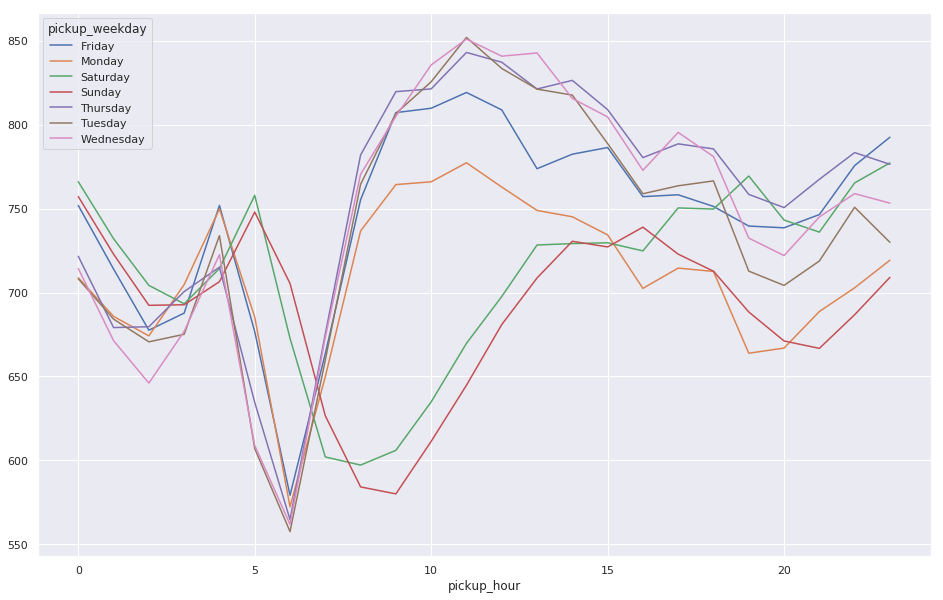

In [214]:
avg_trip_duration_per_weekday = df_train.groupby(['pickup_weekday', 'pickup_hour'])['trip_duration'].mean()
avg_trip_duration_per_weekday.unstack(level=0).plot(subplots=False)

holiday
False    741.867259
True     658.135834
Name: trip_duration, dtype: float64

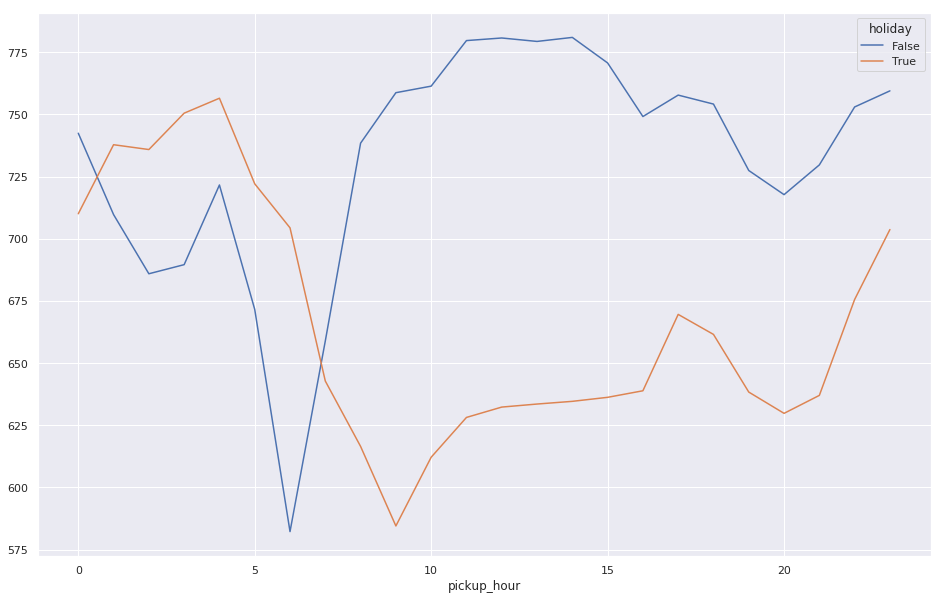

In [215]:
avg_trip_duration_holiday = df_train.groupby(['holiday','pickup_hour'])['trip_duration'].mean()
avg_trip_duration_holiday.unstack(level=0).plot(subplots=False)
df_train.groupby(['holiday'])['trip_duration'].mean()

#### Store and Forward

store_and_fwd_flag
N    739.826014
Y    829.073560
Name: trip_duration, dtype: float64

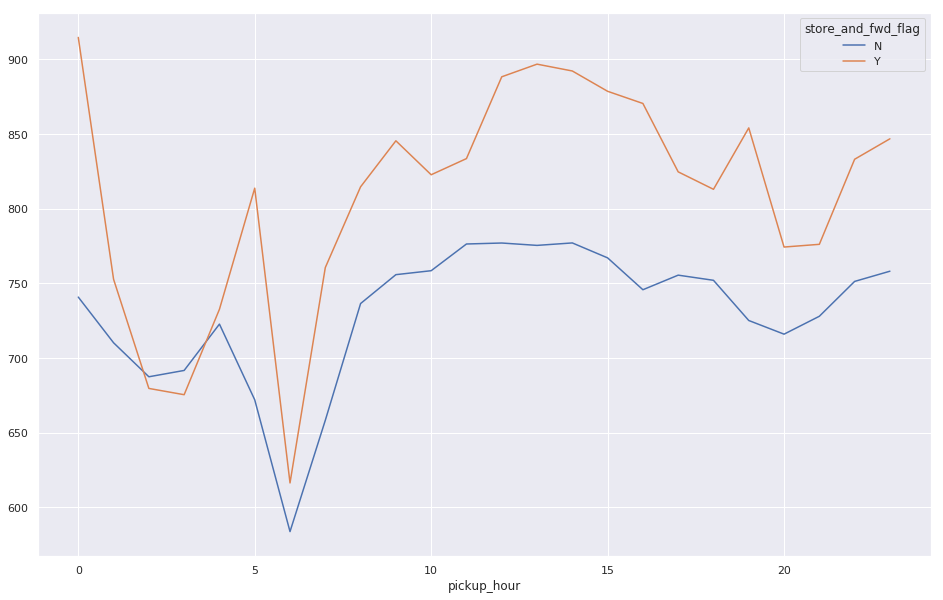

In [216]:
avg_trip_duration_per_store_flag = df_train.groupby(['store_and_fwd_flag','pickup_hour'])['trip_duration'].mean()
avg_trip_duration_per_store_flag.unstack(level=0).plot(subplots=False)
df_train.groupby(['store_and_fwd_flag'])['trip_duration'].mean()

#### Number of Passangers

passenger_count
0    854.500000
1    734.706776
2    758.300403
3    760.249816
4    764.539607
5    743.378891
6    737.879997
Name: trip_duration, dtype: float64

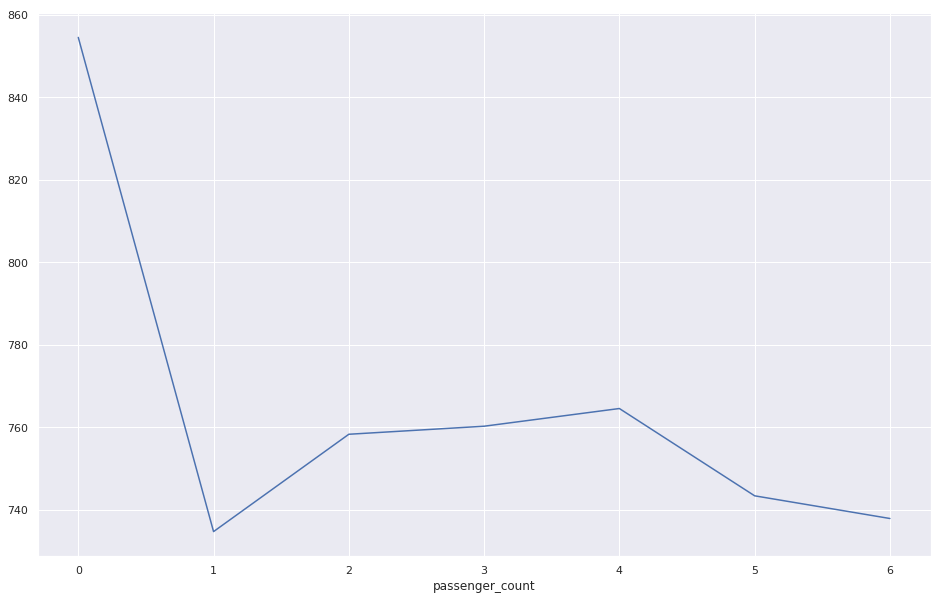

In [217]:
avg_trip_duration_per_passenger_count = df_train.groupby(['passenger_count'])['trip_duration'].mean()
avg_trip_duration_per_passenger_count.plot()
# avg_trip_duration_per_passenger_count = df_train.groupby(['passenger_count','pickup_hour'])['trip_duration'].mean()
# avg_trip_duration_per_passenger_count.unstack(level=0).plot(subplots=False)
df_train.groupby(['passenger_count'])['trip_duration'].mean()

#### Trip Duration per Vendor Id

In [205]:
avg_trip_duration_per_vendor_id = df_train.groupby(['vendor_id'])['trip_duration'].mean()
avg_trip_duration_per_vendor_id

vendor_id
1    739.118477
2    741.285457
Name: trip_duration, dtype: float64